## Problem Statement 

You need to build a model that is able to classify customer complaints based on the products/services. By doing so, you can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

You will be doing topic modelling on the <b>.json</b> data provided by the company. Since this data is not labelled, you need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others 


With the help of topic modelling, you will be able to map each ticket onto its respective department/category. You can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, you can classify any new customer complaint support ticket into its relevant department.

## Pipelines that needs to be performed:

You need to perform the following eight major tasks to complete the assignment:

1.  Data loading

2. Text preprocessing

3. Exploratory data analysis (EDA)

4. Feature extraction

5. Topic modelling 

6. Model building using supervised learning

7. Model training and evaluation

8. Model inference

## Importing the necessary libraries

In [1]:
import json 
import numpy as np
import pandas as pd
#nltk.download('all')
import re, nltk, spacy, string
import en_core_web_sm
nlp = en_core_web_sm.load()
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from pprint import pprint

import warnings
warnings.filterwarnings('ignore')

## Loading the data

The data is in JSON format and we need to convert it to a dataframe.

In [2]:
# Opening JSON file 
f = open('/kaggle/input/ticket-classification-dataset/complaints-2021-05-14_08_16.json')# Write the path to your data file and load it 
  
# returns JSON object as  
# a dictionary 
data = json.load(f)
df=pd.json_normalize(data)

## Data preparation

In [3]:
# Inspect the dataframe to understand the given data.
df.head()


,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,...,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78313 entries, 0 to 78312
Data columns (total 22 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   _index                             78313 non-null  object 
 1   _type                              78313 non-null  object 
 2   _id                                78313 non-null  object 
 3   _score                             78313 non-null  float64
 4   _source.tags                       10900 non-null  object 
 5   _source.zip_code                   71556 non-null  object 
 6   _source.complaint_id               78313 non-null  object 
 7   _source.issue                      78313 non-null  object 
 8   _source.date_received              78313 non-null  object 
 9   _source.state                      76322 non-null  object 
 10  _source.consumer_disputed          78313 non-null  object 
 11  _source.product                    78313 non-null  obj

In [5]:
df.shape

(78313, 22)

In [6]:
#print the column names
df.columns

Index(['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code',
       '_source.complaint_id', '_source.issue', '_source.date_received',
       '_source.state', '_source.consumer_disputed', '_source.product',
       '_source.company_response', '_source.company', '_source.submitted_via',
       '_source.date_sent_to_company', '_source.company_public_response',
       '_source.sub_product', '_source.timely',
       '_source.complaint_what_happened', '_source.sub_issue',
       '_source.consumer_consent_provided'],
      dtype='object')

In [7]:
#Assign new column names
df.columns = [col.replace('_source.', '') for col in df.columns]
df.columns = df.columns.str.lstrip("_") 

print(df.columns)

Index(['index', 'type', 'id', 'score', 'tags', 'zip_code', 'complaint_id',
       'issue', 'date_received', 'state', 'consumer_disputed', 'product',
       'company_response', 'company', 'submitted_via', 'date_sent_to_company',
       'company_public_response', 'sub_product', 'timely',
       'complaint_what_happened', 'sub_issue', 'consumer_consent_provided'],
      dtype='object')


In [8]:
df.isnull().sum()*100/df.shape[0]

index                         0.000000
type                          0.000000
id                            0.000000
score                         0.000000
tags                         86.081493
zip_code                      8.628197
complaint_id                  0.000000
issue                         0.000000
date_received                 0.000000
state                         2.542362
consumer_disputed             0.000000
product                       0.000000
company_response              0.000000
company                       0.000000
submitted_via                 0.000000
date_sent_to_company          0.000000
company_public_response      99.994892
sub_product                  13.498397
timely                        0.000000
complaint_what_happened       0.000000
sub_issue                    59.117899
consumer_consent_provided     1.287143
dtype: float64

In [9]:
df[df.loc[:, 'complaint_what_happened'] == '']

,index,type,id,score,tags,zip_code,complaint_id,issue,date_received,state,...,company_response,company,submitted_via,date_sent_to_company,company_public_response,sub_product,timely,complaint_what_happened,sub_issue,consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A
5,complaint-public-v2,complaint,3275312,0.0,Older American,48227,3275312,Managing an account,2019-06-13T12:00:00-05:00,MI,...,Closed with monetary relief,JPMORGAN CHASE & CO.,Referral,2019-06-14T12:00:00-05:00,None,Checking account,Yes,,Problem using a debit or ATM card,N/A
6,complaint-public-v2,complaint,3238804,0.0,None,76262,3238804,Managing an account,2019-05-10T12:00:00-05:00,TX,...,Closed with monetary relief,JPMORGAN CHASE & CO.,Phone,2019-05-10T12:00:00-05:00,None,Checking account,Yes,,Problem using a debit or ATM card,N/A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78304,complaint-public-v2,complaint,3080086,0.0,None,76107,3080086,Applying for a mortgage or refinancing an exis...,2018-11-22T12:00:00-05:00,TX,...,Closed with monetary relief,JPMORGAN CHASE & CO.,Web,2018-11-22T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Other
78305,complaint-public-v2,complaint,3103013,0.0,Older American,863XX,3103013,Closing an account,2018-12-17T12:00:00-05:00,AZ,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2018-12-18T12:00:00-05:00,None,Other banking product or service,Yes,,Funds not received from closed account,Consent not provided
78306,complaint-public-v2,complaint,3099437,0.0,None,11217,3099437,Managing an account,2018-12-12T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2018-12-18T12:00:00-05:00,None,Checking account,Yes,,Deposits and withdrawals,N/A
78307,complaint-public-v2,complaint,3156336,0.0,None,074XX,3156336,Applying for a mortgage or refinancing an exis...,2019-02-19T12:00:00-05:00,NJ,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-02-19T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Other


In [10]:
#Assign nan in place of blanks in the complaints column
df[df.loc[:, 'complaint_what_happened'] == ''] = np.nan
df[df.loc[:, 'complaint_what_happened'] == '']

,index,type,id,score,tags,zip_code,complaint_id,issue,date_received,state,...,company_response,company,submitted_via,date_sent_to_company,company_public_response,sub_product,timely,complaint_what_happened,sub_issue,consumer_consent_provided


In [11]:
#Remove all rows where complaints column is nan
df = df[~df['complaint_what_happened'].isnull()]

In [12]:
df.shape

(21072, 22)

## Prepare the text for topic modeling

Once you have removed all the blank complaints, you need to:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers


Once you have done these cleaning operations you need to perform the following:
* Lemmatize the texts
* Extract the POS tags of the lemmatized text and remove all the words which have tags other than NN[tag == "NN"].


In [13]:
# Write your function here to clean the text and remove all the unnecessary elements.
def clean_text(sent):
    sent = sent.lower() # Make the text lowercase
    sent = re.sub("([\(\[]).*?([\)\]])", "\g<1>\g<2>", sent)# Remove text in square brackets
    sent = re.sub(r"[\([{})\]]", '', sent) #Remove brackets
    pattern = '[^\w\s]' # Remove punctuation
    sent = re.sub(pattern, '', sent) 
    pattern = '\w*\d\w*' # Remove words containing numbers
    sent = re.sub(pattern, '', sent) 
    
    return sent

In [14]:
#Write your function to Lemmatize the texts
def lemmmatize(text):
    sentence = []
    doc = nlp(text)
    for token in doc:
        sentence.append(token.lemma_)
    return " ".join(sentence)

In [15]:
#Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints 
df_clean = pd.DataFrame(df['complaint_what_happened'].apply(clean_text))
df_clean['complaint_lemmatized'] = df_clean['complaint_what_happened'].apply(lemmmatize)

In [16]:
df_clean

,complaint_what_happened,complaint_lemmatized
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...
2,i upgraded my xxxx xxxx card in and was told ...,I upgrade my xxxx xxxx card in and be tell b...
10,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...
11,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...
14,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...
...,...,...
78303,after being a chase card customer for well ove...,after be a chase card customer for well over a...
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,on wednesday xxxxxxxx I call cha my xxxx xxxx ...
78310,i am not familiar with xxxx pay and did not un...,I be not familiar with xxxx pay and do not und...
78311,i have had flawless credit for yrs ive had ch...,I have have flawless credit for yrs I ve hav...


In [17]:
# !pip install textblob
from textblob import TextBlob

In [18]:
#Write your function to extract the POS tags 
def pos_tag(text):
    sent = []
    blob = TextBlob(text)
    #doc = nlp(text)
    sent = [word for (word,tag) in blob.tags if tag=='NN']
    #sent = [token.text for token in doc if token.pos_=='NN']
    return " ".join(sent)



df_clean["complaint_POS_removed"] =  df_clean['complaint_lemmatized'].apply(pos_tag)#this column should contain lemmatized text with all the words removed which have tags other than NN[tag == "NN"].


In [19]:
#The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.
df_clean

,complaint_what_happened,complaint_lemmatized,complaint_POS_removed
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank cardmember service ask ...
2,i upgraded my xxxx xxxx card in and was told ...,I upgrade my xxxx xxxx card in and be tell b...,card agent upgrade date agent information orde...
10,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...,card report application identity consent servi...
11,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...,try book xxxx ticket offer ticket card informa...
14,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...,son chase account fund bank account pay money ...
...,...,...,...
78303,after being a chase card customer for well ove...,after be a chase card customer for well over a...,card customer decade solicitation credit card ...
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,on wednesday xxxxxxxx I call cha my xxxx xxxx ...,visa credit card provider claim purchase prote...
78310,i am not familiar with xxxx pay and did not un...,I be not familiar with xxxx pay and do not und...,pay risk provide consumer bank app chase year ...
78311,i have had flawless credit for yrs ive had ch...,I have have flawless credit for yrs I ve hav...,credit yrs credit card chase freedom xxxx prob...


## Exploratory data analysis to get familiar with the data.

Write the code in this task to perform the following:

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘




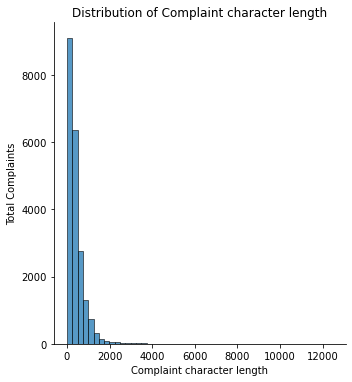

In [20]:
# Write your code here to visualise the data according to the 'Complaint' character length
character_len = [len(sent) for sent in df_clean['complaint_POS_removed']]

sns.displot(character_len, kind='hist', bins=50)
plt.xlabel("Complaint character length")
plt.ylabel("Total Complaints")
plt.title("Distribution of Complaint character length")
plt.show()

In [21]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

#### Find the top 40 words by frequency among all the articles after processing the text.

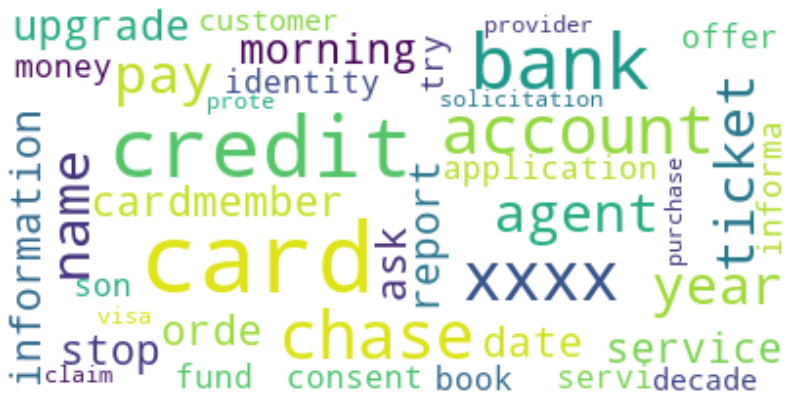

In [22]:
#Using a word cloud find the top 40 words by frequency among all the articles after processing the text
stopwords = set(STOPWORDS)
wordcloud = WordCloud(max_font_size=50, max_words=40, 
                      background_color="white", random_state=100, 
                      stopwords=stopwords).generate(str(df_clean['complaint_POS_removed']))
plt.figure(figsize=[14,14])
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

Top words are credit, card, bank, account, pay

In [23]:
#Removing -PRON- from the text corpus
df_clean['Complaint_clean'] = df_clean['complaint_POS_removed'].str.replace('-PRON-', '')

In [24]:
from nltk.util import ngrams
from sklearn.feature_extraction.text import CountVectorizer
def top_ngrams(text, n=None, ngram=None):
    ngrams = ngrams(text.split(), ngram)
    for item in ngrams:
        print(item)

def get_top_ngrams(text, n=None, ngram=(1,1)):
    word_vectorizer = CountVectorizer(ngram_range=ngram, analyzer='word')
    sparse_matrix = word_vectorizer.fit_transform(text)
    frequencies = sum(sparse_matrix).toarray()[0]
    words_frequency_df= pd.DataFrame(frequencies, index=word_vectorizer.get_feature_names_out(), columns=['frequency'])
    words_frequency_df = words_frequency_df.sort_values(by=['frequency'], ascending=False)
    return words_frequency_df.head(n)

#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

In [25]:
#Write your code here to find the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean). 
top_30_words = get_top_ngrams(df_clean['Complaint_clean'], n=30, ngram=(1,1))
top_30_words

,frequency
account,46780
chase,45739
xxxx,35059
credit,33593
card,28709
bank,27933
payment,20846
time,15681
charge,14770
check,12918


In [26]:
#Print the top 10 words in the unigram frequency
top_30_words.head(10).index

Index(['account', 'chase', 'xxxx', 'credit', 'card', 'bank', 'payment', 'time',
       'charge', 'check'],
      dtype='object')

In [27]:
#Write your code here to find the top 30 bigram frequency among the complaints in the cleaned datafram(df_clean). 
top_30_bigram_words = get_top_ngrams(df_clean['Complaint_clean'], n=30, ngram=(2,2))
top_30_bigram_words

,frequency
credit card,12537
credit report,3902
xxxx xxxx,3672
check account,3052
customer service,3043
chase credit,2877
chase bank,2859
bank account,2641
account chase,2460
chase account,2215


In [28]:
#Print the top 10 words in the bigram frequency
top_30_bigram_words.head(10)

,frequency
credit card,12537
credit report,3902
xxxx xxxx,3672
check account,3052
customer service,3043
chase credit,2877
chase bank,2859
bank account,2641
account chase,2460
chase account,2215


In [29]:
#Write your code here to find the top 30 trigram frequency among the complaints in the cleaned datafram(df_clean). 
top_30_trigram_words = get_top_ngrams(df_clean['Complaint_clean'], n=30, ngram=(3,3))
top_30_trigram_words

,frequency
chase credit card,2030
credit card account,982
credit card company,968
credit card chase,589
credit card credit,482
inquiry credit report,477
charge credit card,403
xxxx xxxx xxxx,374
credit reporting agency,374
account credit card,370


In [30]:
#Print the top 10 words in the trigram frequency
top_30_trigram_words.head(10)

,frequency
chase credit card,2030
credit card account,982
credit card company,968
credit card chase,589
credit card credit,482
inquiry credit report,477
charge credit card,403
xxxx xxxx xxxx,374
credit reporting agency,374
account credit card,370


## The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis

In [31]:
df_clean['Complaint_clean'] = df_clean['Complaint_clean'].str.replace('xxxx','')

In [32]:
#All masked texts has been removed
df_clean

,complaint_what_happened,complaint_lemmatized,complaint_POS_removed,Complaint_clean
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank cardmember service ask ...,morning name stop bank cardmember service ask ...
2,i upgraded my xxxx xxxx card in and was told ...,I upgrade my xxxx xxxx card in and be tell b...,card agent upgrade date agent information orde...,card agent upgrade date agent information orde...
10,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...,card report application identity consent servi...,card report application identity consent servi...
11,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...,try book xxxx ticket offer ticket card informa...,try book ticket offer ticket card information...
14,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...,son chase account fund bank account pay money ...,son chase account fund bank account pay money ...
...,...,...,...,...
78303,after being a chase card customer for well ove...,after be a chase card customer for well over a...,card customer decade solicitation credit card ...,card customer decade solicitation credit card ...
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,on wednesday xxxxxxxx I call cha my xxxx xxxx ...,visa credit card provider claim purchase prote...,visa credit card provider claim purchase prote...
78310,i am not familiar with xxxx pay and did not un...,I be not familiar with xxxx pay and do not und...,pay risk provide consumer bank app chase year ...,pay risk provide consumer bank app chase year ...
78311,i have had flawless credit for yrs ive had ch...,I have have flawless credit for yrs I ve hav...,credit yrs credit card chase freedom xxxx prob...,credit yrs credit card chase freedom problem ...


## Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [33]:
#Write your code here to initialise the TfidfVectorizer 

tfidf = TfidfVectorizer(min_df=2, max_df=0.95, stop_words='english')

#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [34]:
#Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.
document_term_matrix = tfidf.fit_transform(df_clean['Complaint_clean'])

In [35]:
document_term_matrix

<21072x7104 sparse matrix of type '<class 'numpy.float64'>'
	with 632823 stored elements in Compressed Sparse Row format>

## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task you have to perform the following:

* Find the best number of clusters 
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints 
* Correct the labels if needed 
* Map the clusters to topics/cluster names

In [36]:
from sklearn.decomposition import NMF

## Manual Topic Modeling
You need to do take the trial & error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

In [37]:
#Load your nmf_model with the n_components i.e 5
num_topics = 5#write the value you want to test out

#keep the random_state =40
nmf_model = NMF(n_components=num_topics, random_state=40)#write your code here

In [38]:
nmf_model.fit(document_term_matrix)
len(tfidf.get_feature_names_out())

7104

In [39]:
H = nmf_model.components_
H

array([[4.94644366e-04, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 8.92493502e-04, 9.10365486e-05],
       [0.00000000e+00, 3.28665084e-03, 0.00000000e+00, ...,
        2.47957031e-04, 0.00000000e+00, 2.10214831e-04],
       [0.00000000e+00, 3.21691398e-04, 0.00000000e+00, ...,
        0.00000000e+00, 8.81201502e-04, 0.00000000e+00],
       [3.26844496e-04, 2.24759931e-03, 0.00000000e+00, ...,
        2.72163740e-04, 2.91771008e-03, 5.40620106e-04],
       [0.00000000e+00, 3.51365449e-04, 1.45266411e-03, ...,
        8.44214259e-04, 3.27900016e-03, 0.00000000e+00]])

In [40]:
#Print the Top15 words for each of the topics
words = np.array(tfidf.get_feature_names_out ())
topic_words = pd.DataFrame(np.zeros((num_topics, 15)), index=[f'Topic {i + 1}' for i in range(num_topics)],
                           columns=[f'Word {i + 1}' for i in range(15)]).astype(str)
for i in range(num_topics):
    ix = H[i].argsort()[::-1][:15]
    topic_words.iloc[i] = words[ix]

topic_words

,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,Word 15
Topic 1,account,check,bank,money,fund,chase,deposit,branch,day,number,business,transaction,claim,transfer,customer
Topic 2,credit,card,report,inquiry,chase,account,score,company,limit,information,debt,application,letter,year,balance
Topic 3,payment,balance,month,fee,statement,day,time,auto,date,pay,credit,account,chase,year,error
Topic 4,charge,card,fee,transaction,dispute,chase,merchant,fraud,purchase,claim,service,time,statement,refund,company
Topic 5,loan,mortgage,home,chase,modification,property,year,letter,rate,time,document,bank,house,foreclosure,sale


In [41]:
#Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4

topic_results = nmf_model.transform(document_term_matrix)

In [42]:
#Assign the best topic to each of the cmplaints in Topic Column

df_clean['Topic'] = topic_results.argmax(axis=1)#write your code to assign topics to each rows.

In [43]:
df_clean.shape

(21072, 5)

In [44]:
df_clean.head()

,complaint_what_happened,complaint_lemmatized,complaint_POS_removed,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank cardmember service ask ...,morning name stop bank cardmember service ask ...,4
2,i upgraded my xxxx xxxx card in and was told ...,I upgrade my xxxx xxxx card in and be tell b...,card agent upgrade date agent information orde...,card agent upgrade date agent information orde...,1
10,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...,card report application identity consent servi...,card report application identity consent servi...,1
11,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...,try book xxxx ticket offer ticket card informa...,try book ticket offer ticket card information...,1
14,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...,son chase account fund bank account pay money ...,son chase account fund bank account pay money ...,0


In [45]:
#Print the first 5 Complaint for each of the Topics
df_clean_5=df_clean.groupby('Topic').head(5)
df_clean_5.sort_values('Topic')

,complaint_what_happened,complaint_lemmatized,complaint_POS_removed,Complaint_clean,Topic
14,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...,son chase account fund bank account pay money ...,son chase account fund bank account pay money ...,0
17,with out notice jp morgan chase restricted my ...,with out notice jp morgan chase restrict my ac...,jp chase account debit card tuesday thursday b...,jp chase account debit card tuesday thursday b...,0
24,mishandling of this account by chase auto and ...,mishandle of this account by chase auto and xxxx,mishandle account auto xxxx,mishandle account auto,0
27,i opened an account with chase bank on xxxx an...,I open an account with chase bank on xxxx and ...,account bank code bonus term everything accoun...,account bank code bonus term everything accoun...,0
35,i opened the saving account for the bonus i w...,I open the saving account for the bonus I be...,account bonus bonus auto transfer check transf...,account bonus bonus auto transfer check transf...,0
2,i upgraded my xxxx xxxx card in and was told ...,I upgrade my xxxx xxxx card in and be tell b...,card agent upgrade date agent information orde...,card agent upgrade date agent information orde...,1
10,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...,card report application identity consent servi...,card report application identity consent servi...,1
11,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...,try book xxxx ticket offer ticket card informa...,try book ticket offer ticket card information...,1
15,can you please remove inquiry,can you please remove inquiry,inquiry,inquiry,1
23,i have a chase credit card which is incorrectl...,I have a chase credit card which be incorrectl...,chase credit card datum credit report company ...,chase credit card datum credit report company ...,1


#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

In [46]:
#Create the dictionary of Topic names and Topics

Topic_names = { 0:"Bank account services", 1:"Credit card / Prepaid card", 2:"Others",
               3:"Theft/Dispute reporting", 4:"Mortgages/loans"  }
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [47]:
df_clean

,complaint_what_happened,complaint_lemmatized,complaint_POS_removed,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank cardmember service ask ...,morning name stop bank cardmember service ask ...,Mortgages/loans
2,i upgraded my xxxx xxxx card in and was told ...,I upgrade my xxxx xxxx card in and be tell b...,card agent upgrade date agent information orde...,card agent upgrade date agent information orde...,Credit card / Prepaid card
10,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...,card report application identity consent servi...,card report application identity consent servi...,Credit card / Prepaid card
11,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...,try book xxxx ticket offer ticket card informa...,try book ticket offer ticket card information...,Credit card / Prepaid card
14,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...,son chase account fund bank account pay money ...,son chase account fund bank account pay money ...,Bank account services
...,...,...,...,...,...
78303,after being a chase card customer for well ove...,after be a chase card customer for well over a...,card customer decade solicitation credit card ...,card customer decade solicitation credit card ...,Credit card / Prepaid card
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,on wednesday xxxxxxxx I call cha my xxxx xxxx ...,visa credit card provider claim purchase prote...,visa credit card provider claim purchase prote...,Theft/Dispute reporting
78310,i am not familiar with xxxx pay and did not un...,I be not familiar with xxxx pay and do not und...,pay risk provide consumer bank app chase year ...,pay risk provide consumer bank app chase year ...,Theft/Dispute reporting
78311,i have had flawless credit for yrs ive had ch...,I have have flawless credit for yrs I ve hav...,credit yrs credit card chase freedom xxxx prob...,credit yrs credit card chase freedom problem ...,Others


## Supervised model to predict any new complaints to the relevant Topics.

You have now build the model to create the topics for each complaints.Now in the below section you will use them to classify any new complaints.

Since you will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

In [48]:
#Create the dictionary again of Topic names and Topics

Topic_names = {"Bank account services":0, "Credit card / Prepaid card":1, "Others":2,
               "Theft/Dispute reporting":3, "Mortgages/loans":4   }
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [49]:
df_clean

,complaint_what_happened,complaint_lemmatized,complaint_POS_removed,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank cardmember service ask ...,morning name stop bank cardmember service ask ...,4
2,i upgraded my xxxx xxxx card in and was told ...,I upgrade my xxxx xxxx card in and be tell b...,card agent upgrade date agent information orde...,card agent upgrade date agent information orde...,1
10,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...,card report application identity consent servi...,card report application identity consent servi...,1
11,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...,try book xxxx ticket offer ticket card informa...,try book ticket offer ticket card information...,1
14,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...,son chase account fund bank account pay money ...,son chase account fund bank account pay money ...,0
...,...,...,...,...,...
78303,after being a chase card customer for well ove...,after be a chase card customer for well over a...,card customer decade solicitation credit card ...,card customer decade solicitation credit card ...,1
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,on wednesday xxxxxxxx I call cha my xxxx xxxx ...,visa credit card provider claim purchase prote...,visa credit card provider claim purchase prote...,3
78310,i am not familiar with xxxx pay and did not un...,I be not familiar with xxxx pay and do not und...,pay risk provide consumer bank app chase year ...,pay risk provide consumer bank app chase year ...,3
78311,i have had flawless credit for yrs ive had ch...,I have have flawless credit for yrs I ve hav...,credit yrs credit card chase freedom xxxx prob...,credit yrs credit card chase freedom problem ...,2


In [50]:
df_clean.shape

(21072, 5)

In [51]:
#Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data
training_data=df_clean[['complaint_what_happened', 'Topic']]

In [52]:
training_data

,complaint_what_happened,Topic
1,good morning my name is xxxx xxxx and i apprec...,4
2,i upgraded my xxxx xxxx card in and was told ...,1
10,chase card was reported on however fraudulent...,1
11,on while trying to book a xxxx xxxx ticket ...,1
14,my grand son give me check for i deposit it i...,0
...,...,...
78303,after being a chase card customer for well ove...,1
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,3
78310,i am not familiar with xxxx pay and did not un...,3
78311,i have had flawless credit for yrs ive had ch...,2


####Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [53]:

#Write your code to get the Vector count
import pickle
vect = CountVectorizer()
X_train_count = vect.fit_transform(training_data['complaint_what_happened'])

pickle.dump(vect.vocabulary_, open("count_vector.pk1", "wb"))

#Write your code here to transform the word vector to tf-idf
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_count)

pickle.dump(tfidf_transformer, open('tfidf.pk1', "wb"))

You have to try atleast 3 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

In [54]:
# Write your code here to build any 3 models and evaluate them using the required metrics
#Model 1
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_train_tfidf, training_data['Topic'], test_size=0.25, random_state=40)

In [55]:
log_reg = LogisticRegression(random_state=40, solver='liblinear').fit(X_train, y_train)

In [56]:
log_reg.score(X_test, y_test)

0.9179954441913439

In [57]:
X_train_tfidf

<21072x33069 sparse matrix of type '<class 'numpy.float64'>'
	with 2250304 stored elements in Compressed Sparse Row format>

In [58]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(random_state=40)
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]
# define grid search
grid = dict(solver=solvers,penalty=penalty,C=c_values)
#cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=5, scoring='accuracy',verbose=True)
grid_result = grid_search.fit(X_train, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Fitting 5 folds for each of 15 candidates, totalling 75 fits
Best: 0.924893 using {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
0.918755 (0.003147) with: {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
0.922994 (0.004473) with: {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
0.909390 (0.003947) with: {'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}
0.924829 (0.004143) with: {'C': 10, 'penalty': 'l2', 'solver': 'newton-cg'}
0.924893 (0.003837) with: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
0.919325 (0.004468) with: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
0.919641 (0.004741) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'newton-cg'}
0.919641 (0.005008) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'lbfgs'}
0.914389 (0.005049) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear'}
0.881739 (0.005389) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'newton-cg'}
0.881739 (0.005389) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
0.871299 (0.006467) with: {'C': 0.1, 'penalt

In [59]:
grid_search.best_params_

{'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}

In [60]:
# Evaluating the tuned model
grid_search.score(X_test, y_test)

0.9242596810933941

After hyperparameter tuning, th elogestic regression accuracy imporved to 0.922% from 0.919 

In [61]:
# Save Logistic Regression Model
pickle.dump(grid_search, open("logreg_model.pk1", "wb"))

Log Reg Model Evaluation

In [62]:
from sklearn.metrics import confusion_matrix, classification_report
# Load pickled model
grid_search = pickle.load(open("logreg_model.pk1", "rb"))
# Make predictions on test data
y_pred = grid_search.predict(X_test)
# Print Confusion Matrix
print(confusion_matrix(y_test, y_pred))

[[1249   12    5   39   10]
 [  16 1152    7   53   10]
 [  16   16  517   17   16]
 [  46   51    8 1078   12]
 [  23   16    8   18  873]]


In [63]:
# Print Classification Report
print(classification_report(y_test, y_pred, target_names = ["Bank account services", "Credit card / Prepaid card", "Others", "Theft/Dispute reporting", "Mortgages/loans"]))

                            precision    recall  f1-score   support

     Bank account services       0.93      0.95      0.94      1315
Credit card / Prepaid card       0.92      0.93      0.93      1238
                    Others       0.95      0.89      0.92       582
   Theft/Dispute reporting       0.89      0.90      0.90      1195
           Mortgages/loans       0.95      0.93      0.94       938

                  accuracy                           0.92      5268
                 macro avg       0.93      0.92      0.92      5268
              weighted avg       0.92      0.92      0.92      5268



#Model 2: Decision Tree Classifier

In [64]:
# Importing DecisionTreeClassifier from sklearn
from sklearn.tree import DecisionTreeClassifier

In [65]:
decision_tree_model = DecisionTreeClassifier(random_state=40).fit(X_train, y_train)

In [66]:
decision_tree_model.score(X_test, y_test)

0.7815110098709187

In [67]:
#HyperParameter Tuning
dt_model = DecisionTreeClassifier(random_state=40)
# define grid search
dt_grid = dict(max_depth= [3, 5, 9],
           min_samples_split= np.arange(2, 20, 2),
           min_samples_leaf= np.arange(1, 20, 2))
dt_grid_search = GridSearchCV(estimator=dt_model, param_grid=dt_grid, n_jobs=-1, cv=5, scoring='accuracy',verbose=True)
dt_grid_result = dt_grid_search.fit(X_train, y_train)
# summarize results
print("Best: %f using %s" % (dt_grid_search.best_score_, dt_grid_search.best_params_))
means = dt_grid_result.cv_results_['mean_test_score']
stds = dt_grid_result.cv_results_['std_test_score']
params = dt_grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Fitting 5 folds for each of 270 candidates, totalling 1350 fits
Best: 0.755759 using {'max_depth': 9, 'min_samples_leaf': 17, 'min_samples_split': 2}
0.619527 (0.009053) with: {'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2}
0.619527 (0.009053) with: {'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 4}
0.619527 (0.009053) with: {'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 6}
0.619527 (0.009053) with: {'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 8}
0.619527 (0.009053) with: {'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 10}
0.619527 (0.009053) with: {'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 12}
0.619527 (0.009053) with: {'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 14}
0.619527 (0.009053) with: {'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 16}
0.619527 (0.009053) with: {'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 18}
0.619527 (0.009053) with: {'max_dep

In [68]:
# Check best parameters
dt_grid_search.best_params_

{'max_depth': 9, 'min_samples_leaf': 17, 'min_samples_split': 2}

In [69]:
# Evaluating the tuned model
dt_grid_search.score(X_test, y_test)

0.7649962034927866

In [70]:
# Save Logistic Regression Model
pickle.dump(dt_grid_search, open("dt_model.pk1", "wb"))

In [71]:
#Decison Tree Model Evaluation
dt_model = pickle.load(open("dt_model.pk1", "rb"))
y_pred = dt_model.predict(X_test)
print(confusion_matrix(y_test, y_pred))

[[1076   50   30  138   21]
 [  40 1039   27  124    8]
 [  29   45  423   47   38]
 [ 154  133   32  863   13]
 [  77   34   41  157  629]]


In [72]:
# Print Classification Report
print(classification_report(y_test, y_pred, target_names = ["Bank account services", "Credit card / Prepaid card", "Others", "Theft/Dispute reporting", "Mortgages/loans"]))

                            precision    recall  f1-score   support

     Bank account services       0.78      0.82      0.80      1315
Credit card / Prepaid card       0.80      0.84      0.82      1238
                    Others       0.76      0.73      0.75       582
   Theft/Dispute reporting       0.65      0.72      0.68      1195
           Mortgages/loans       0.89      0.67      0.76       938

                  accuracy                           0.76      5268
                 macro avg       0.78      0.76      0.76      5268
              weighted avg       0.77      0.76      0.77      5268



**Model 3:Random Forest Classifier**

In [73]:
# Importing Random Forest Classifier from sklearn
from sklearn.ensemble import RandomForestClassifier

In [74]:
rand_forest = RandomForestClassifier(random_state=40).fit(X_train, y_train)
rand_forest.score(X_test, y_test)

0.826879271070615

In [75]:
#HyperParameter Tuning for Random Forest Classifier using RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV
rf_model = RandomForestClassifier(random_state=40)
# define grid search
rf_grid = dict(n_estimators= np.arange(10, 1000, 50),
           max_depth= [3, 5, 10],
           min_samples_split= np.arange(2, 20, 2),
           min_samples_leaf= np.arange(1, 20, 2),
           max_features= ['sqrt', 'log2'])
rf_grid_search = RandomizedSearchCV(estimator=rf_model, param_distributions=rf_grid, n_jobs=-1, cv=5, scoring='accuracy',verbose=True)
rf_grid_result = rf_grid_search.fit(X_train, y_train)
# summarize results
print("Best: %f using %s" % (rf_grid_search.best_score_, rf_grid_search.best_params_))
means = rf_grid_result.cv_results_['mean_test_score']
stds = rf_grid_result.cv_results_['std_test_score']
params = rf_grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best: 0.719945 using {'n_estimators': 260, 'min_samples_split': 18, 'min_samples_leaf': 5, 'max_features': 'sqrt', 'max_depth': 10}
0.349341 (0.013928) with: {'n_estimators': 860, 'min_samples_split': 2, 'min_samples_leaf': 17, 'max_features': 'log2', 'max_depth': 10}
0.330802 (0.030438) with: {'n_estimators': 310, 'min_samples_split': 2, 'min_samples_leaf': 15, 'max_features': 'log2', 'max_depth': 5}
0.669831 (0.008366) with: {'n_estimators': 860, 'min_samples_split': 8, 'min_samples_leaf': 5, 'max_features': 'sqrt', 'max_depth': 5}
0.286258 (0.019758) with: {'n_estimators': 110, 'min_samples_split': 14, 'min_samples_leaf': 13, 'max_features': 'log2', 'max_depth': 3}
0.285370 (0.019213) with: {'n_estimators': 210, 'min_samples_split': 4, 'min_samples_leaf': 9, 'max_features': 'log2', 'max_depth': 3}
0.667869 (0.008354) with: {'n_estimators': 810, 'min_samples_split': 8, 'min_samples_leaf': 9, 'max_features': 'sqrt', 'max_dep

In [76]:
# Check best parameters
rf_grid_search.best_params_

{'n_estimators': 260,
 'min_samples_split': 18,
 'min_samples_leaf': 5,
 'max_features': 'sqrt',
 'max_depth': 10}

In [77]:
# Evaluating the tuned model
rf_grid_search.score(X_test, y_test)

0.7165907365223994

In [80]:
#HyperParameter Tuning for Random Forest Classifier using GridSearchCV
rf_model = RandomForestClassifier(random_state=40)
# define grid search
rf_grid = dict(n_estimators= [200, 250, 300],
           max_depth= [3, 5, 10],
           min_samples_split= [10, 12, 14],
           min_samples_leaf= [6, 8, 10],
           max_features= ['sqrt', 'log2'])
rf_grid_search = GridSearchCV(estimator=rf_model, param_grid=rf_grid, n_jobs=-1, cv=5, scoring='accuracy',verbose=True)
rf_grid_result = rf_grid_search.fit(X_train, y_train)
# summarize results
print("Best: %f using %s" % (rf_grid_search.best_score_, rf_grid_search.best_params_))
means = rf_grid_result.cv_results_['mean_test_score']
stds = rf_grid_result.cv_results_['std_test_score']
params = rf_grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Fitting 5 folds for each of 162 candidates, totalling 810 fits
Best: 0.721400 using {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 6, 'min_samples_split': 14, 'n_estimators': 300}
0.592761 (0.010608) with: {'max_depth': 3, 'max_features': 'sqrt', 'min_samples_leaf': 6, 'min_samples_split': 10, 'n_estimators': 200}
0.590800 (0.013355) with: {'max_depth': 3, 'max_features': 'sqrt', 'min_samples_leaf': 6, 'min_samples_split': 10, 'n_estimators': 250}
0.592509 (0.012996) with: {'max_depth': 3, 'max_features': 'sqrt', 'min_samples_leaf': 6, 'min_samples_split': 10, 'n_estimators': 300}
0.592761 (0.010608) with: {'max_depth': 3, 'max_features': 'sqrt', 'min_samples_leaf': 6, 'min_samples_split': 12, 'n_estimators': 200}
0.590800 (0.013355) with: {'max_depth': 3, 'max_features': 'sqrt', 'min_samples_leaf': 6, 'min_samples_split': 12, 'n_estimators': 250}
0.592509 (0.012996) with: {'max_depth': 3, 'max_features': 'sqrt', 'min_samples_leaf': 6, 'min_samples_split': 12, 'n_estimat

In [81]:
# Check best parameters
rf_grid_search.best_params_

{'max_depth': 10,
 'max_features': 'sqrt',
 'min_samples_leaf': 6,
 'min_samples_split': 14,
 'n_estimators': 300}

In [82]:
# Evaluating the tuned model
rf_grid_search.score(X_test, y_test)

0.7241837509491268

In [84]:
# Save Random Forest Model
pickle.dump(rf_grid_search, open("rf_model_grid.pk1", "wb"))

In [85]:
#Model Evaluation random forest
# Load pickled model
rf_model = pickle.load(open("rf_model_grid.pk1", "rb"))

In [86]:
# Make predictions on test data
y_pred = rf_model.predict(X_test)

In [87]:
# Print Confusion Matrix
print(confusion_matrix(y_test, y_pred))

[[1184  112    0   17    2]
 [  64 1088    0   84    2]
 [ 150  280    4   64   84]
 [ 170  149    0  872    4]
 [  90  166    0   15  667]]


In [88]:
# Print Classification Report
print(classification_report(y_test, y_pred, target_names = ["Bank account services", "Credit card / Prepaid card", "Others", "Theft/Dispute reporting", "Mortgages/loans"]))

                            precision    recall  f1-score   support

     Bank account services       0.71      0.90      0.80      1315
Credit card / Prepaid card       0.61      0.88      0.72      1238
                    Others       1.00      0.01      0.01       582
   Theft/Dispute reporting       0.83      0.73      0.78      1195
           Mortgages/loans       0.88      0.71      0.79       938

                  accuracy                           0.72      5268
                 macro avg       0.81      0.65      0.62      5268
              weighted avg       0.78      0.72      0.68      5268



**Model inference**

We have created below three models:
1. **Logistic regression** with best parameters as (C': 10, 'penalty': 'l2', 'solver': 'lbfgs') and accuracy as 92.4%.
2. **Decision Tree Classifier** with best parameters as ('max_depth': 9, 'min_samples_leaf': 17, 'min_samples_split': 2) and accuracy as 76.4%.
3. **Random Forest Classifier** with best parameters as ('max_depth': 10,'max_features': 'sqrt','min_samples_leaf': 6,'min_samples_split': 14,'n_estimators': 300) and test accuracy as 72.41%. Also we can see the overfit of precision on 'Others'category.

**Conclusion**

The logistic regression model is the best model with an accuracy of 92.4% with Precision and Recall as 93% and 92% respectively.